<a href="https://colab.research.google.com/github/suhyeon03/DeepLearning/blob/main/RNN%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%8B%9C%EA%B3%84%EC%97%B4_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# step 59
RNN을 활용한 시계열 데이터처리

* 지금까지는 피드포워드 구조의 신경망을 살펴보았다.
* 피드포워드란 데이터를 순서방향으로만 계속 입력해준다는 뜻이다.
* 신호가 한 방향으로만 흘러가기 때문에 입력 신호만으로 출력을 결정한다는 특징이 생긴다.
* 한편 순환 신경망은 아래 그림과 같이 계속 순환 구조를 가지고 있다.

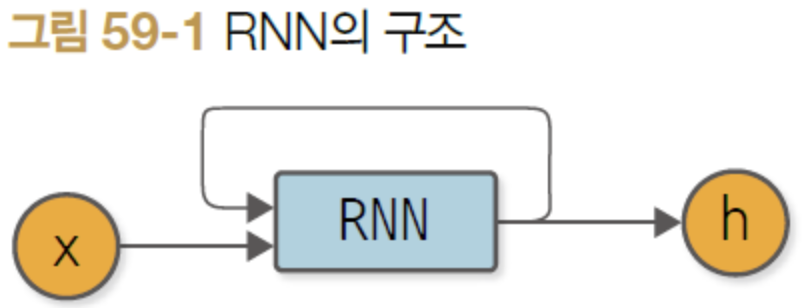

* 그림59-1과 같이 순환 구조 때문에 RNN의 출력은 자신에게 피드백된다.
* 그래서 RNN은 '상태'를 가지게 된다.
* 즉, RNN에 데이터가 입력되면 '상태'가 갱신되고 그 '상태'도 출력에 영향을 준다.
* 이번 단계의 주제는 바로 이 RNN이다. 피드포워드 신경망보다 계산이 복잡하지만 DeZero를 이용하면 간단하게 구현할 수 있다.

RNN 계층 구현
* 먼저 RNN을 수식으로 이해해보자
* 시계열데이터인 입력 x가 있고, 은닉 상태 h를 출력하는 RNN을 생각해보자.
* 여기서 t는 시계열 데이터의 시각(혹은 몇 번째 데이터인지)을 의미한다.
* 또한 RNN의 상태는 은닉 상태라는 점에서 수식 h로 표기했다.
* 아래는 RNN 순전파를 표현한 수식이다.

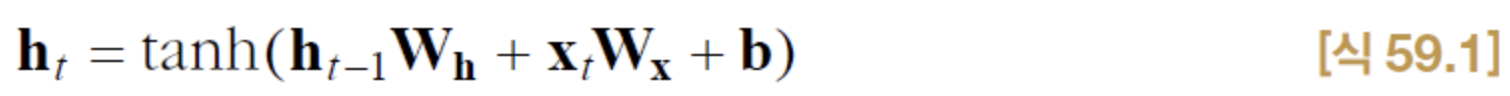

* 먼저 식 59-1에 사용된 각 기호의 뜻을 설명한다.
* RNN에 가중치가 두 개 있다.
* 하나는 입력 x를 은닉 상태 h로 변환하기 위한 가중치 W이고, 또 하나는 RNN의 출력을 다음 시각의 출력으로 변환하기 위한 가중치 W이다.
* 마지막로는 편향 b가 있다.
* 참고로 ht-1, xt는 행벡터이다.

* 식 59-1은 행렬 곱 계산을 수행한 다음, 그 합을 tanh 함수로 변환한다.
* 결괏값을 시각 t에서의 출력 ht이다. 이 ht는 연결된 다음 계층의 입력으로 사용되는 동시에 다음 시각의 RNN계층의 입력으로도 사용된다.

In [7]:

!git clone https://github.com/GoGiants1/dl-from-scratch-3.git
import sys
sys.path.append('dl-from-scratch-3')


Cloning into 'dl-from-scratch-3'...
remote: Enumerating objects: 2327, done.
remote: Counting objects: 100% (2327/2327), done.
remote: Compressing objects: 100% (852/852), done.
remote: Total 2327 (delta 1503), reused 2287 (delta 1463), pack-reused 0 (from 0)
Receiving objects: 100% (2327/2327), 33.93 MiB | 31.76 MiB/s, done.
Resolving deltas: 100% (1503/1503), done.


In [8]:
from dezero import Layer

class RNN(Layer):
    def __init__(self, hidden_size, in_size=None):
        super().__init__()
        self.x2h = Linear(hidden_size, in_size=in_size)
        self.h2h = Linear(hidden_size, in_size=in_size, nobias=True)
        self.h = None

    def reset_state(self):
        self.h = None

    def forward(self, x):
        if self.h is None:
            h_new = F.tanh(self.x2h(x))
        else:
            h_new = F.tanh(self.x2h(x) + self.h2h(self.h))
        self.h = h_new
        return h_new

/content/dl-from-scratch-3/dezero/datasets.py:305: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  return fine_labels if label_type is "fine" else coarse_labels


* 초기화 메서드 __init__는 hidden_size와 in_size를 받는다.
* in_size가 None이라면 은닉계층의 크기만 지정해두고, 입력 크기는 순전파 때 흐르는 데이터로부터 자동으로 구하겠다는 뜻이다.
* 그리고 __init__ 메서드에서 다음 두 Linear 계층을 생성한다.

  * x2h: 입력 x에서 은닉 상태 h로 변환하는 완전연결계층
  * h2h: 이전 은닉 상태에서 다음 은닉 상태로 변환하는 완전연결계층

* 이어서 forward 메서드는 self.h(은닉 상태)의 유뮤에 따라 처리 방식이 달라진다.
* 처음에는 self.h == None이므로 입력 x만으로 은닉상태를 계산한다.
* 두번째 이후로는 앞서 저장해둔 은닉 상태(self.h)를 사용하여 새로운 은닉 상태를 계산한다.
* 마지막으로 reset_state라는 이름으로 은닉 상태 재설정 메서드를 제공한다.
* 식 59-1에서 알 수 있듯이 RNN의 편향은 한 개이다.
* 따라서 x2h의 편향만 사용하고 h2h의 편향은 생략하기도 한다.

In [9]:
import numpy as np
import dezero.layers as L

rnn = L.RNN(10) # 은닉층의 크기만 지정
x = np.random.rand(1, 1)
h = rnn(x)
print(h.shape)

(1, 10)


* 입력 x를 rnn에 주면 은닉 상태 h를 얻을 수 있다.
* 이떄 만들어진 계산 그래프는 그림과 같다.

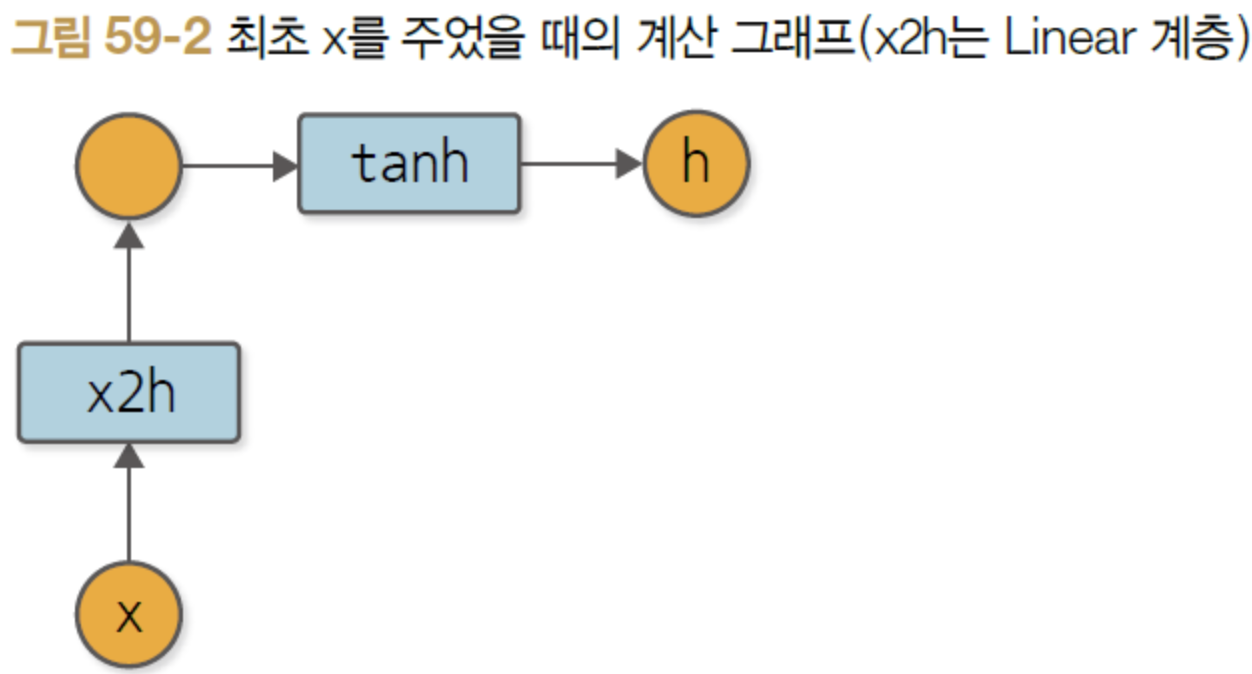

* 계속해서 데이터를 더 주어보자.
* 앞 코드에 바로 이어서 y = rnn(np.random.rand(1,1))을 실행했다고 가정하자.
* 그림 59-3은 이때 만들어지는 계산 그래프이다.

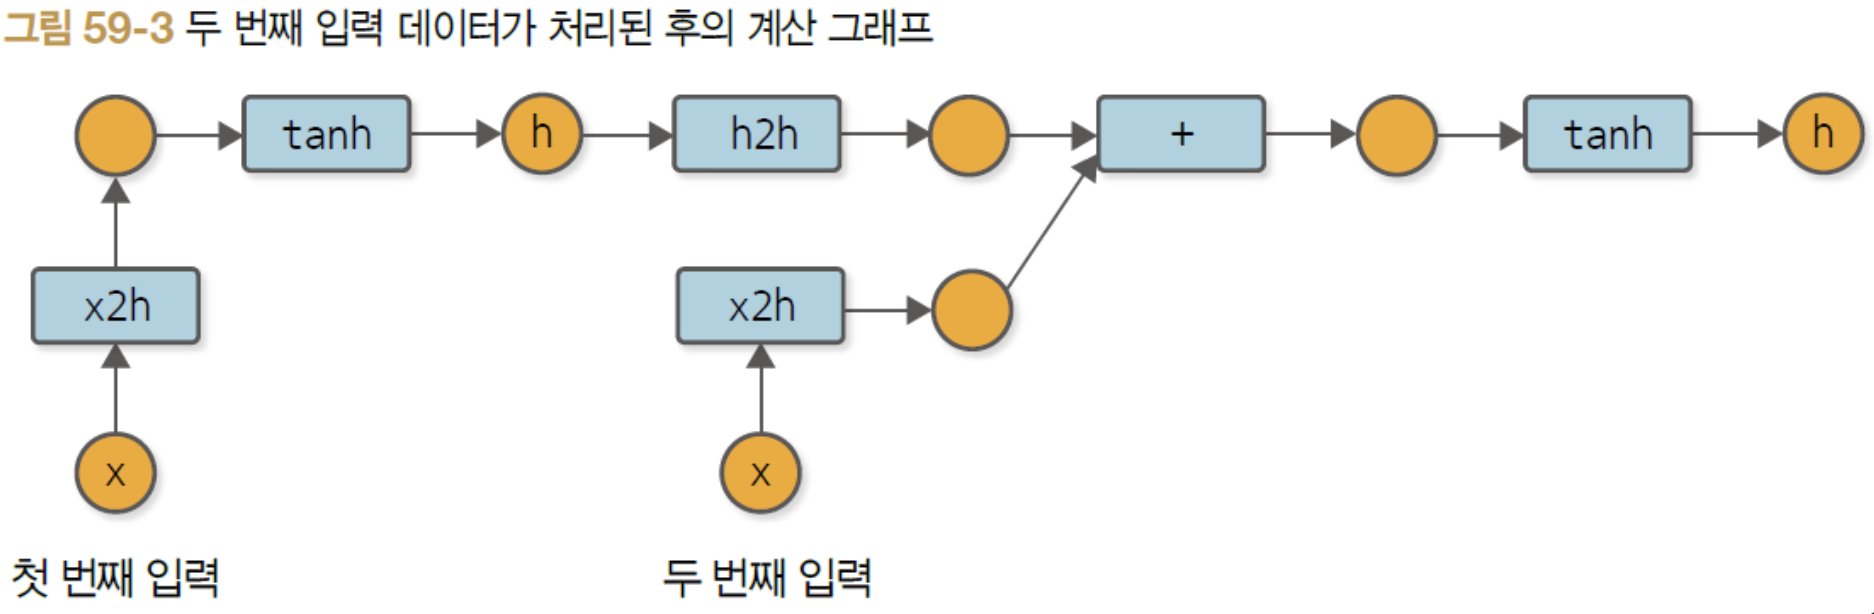

* 그림59-3과 같이 59-2의 그래프가 '성장'하여 더 큰 계산 그래프가 만들어진다.
* 이 계산 그래프의 '성장'을 가능하게 하는 매개체가 바로 RNN의 은닉 상태이다.
* RNN 계산 그래프는 이전의 은닉 상태를 매개로 이전 시각의 계산 그래프와 '연결'되는 것이다.

* 그림 59-3과 같이 RNN은 입력 데이터 '전부'를 포함하는 계산 그래프를 만든다.
* 따라서 입력 데이터들이 어떻게 '연결'되는지도 학습할 수 있다.
* 참고로 그림 59-3에는 x2h가 두 개 등장하지만 모드 같은 Linear인스턴스이며, 가중치도 동일한 것이 사용된다.

RNN 모델 구현

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def __call__(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y

* 이와 같이 인스턴스 변수 fc에 Linear 계층을 추가한다.
* 이 Linear 계층은 RNN 계층의 은닉상태를 입력받아 모델의 최종 출력을 계산한다.
* 그리고 reset_state 메서드는 RNN 계층의 은닉 상태를 재설정하는 역활을 한다.

In [13]:
seq_data = [np.random.rand(1, 1) for _ in range(1000)] # 더비 시계열 데이터
xs = seq_data[0:-1]
ts = seq_data[1:] # 정답 데이터: xs보다 한 단계 앞선 데이터

model = SimpleRNN(10,1)

loss, cnt = 0, 0
for x, t in zip(xs, ts):
    y = model(x)
    loss += F.mean_squared_error(y, t)

    cnt += 1

    if cnt == 2:
        model.cleargrads()
        loss.backward()
        break

* 우선 더미 시계열 데이터인 seq_data를 생성한다.
* 여기에서는 이 시계열 데이터보다 한 단계 앞의 데이터를 예측하는 모델을 학습시키고자 한다.
* 이를 위해 입력 데이터에 대한 정답 데이터로는 한 단계 앞의 데이터를 보관해둔다.
* 다음은 중요한 역전파인데, 여기에서는 예시를 위해 두 번째 입력 데이터가 들어왔을때 역전파를 수행한다.
* 참고로 두 번째 입력 데이터가 들어왔을 때의 계산 그래프는 그림 59-4와 같다.

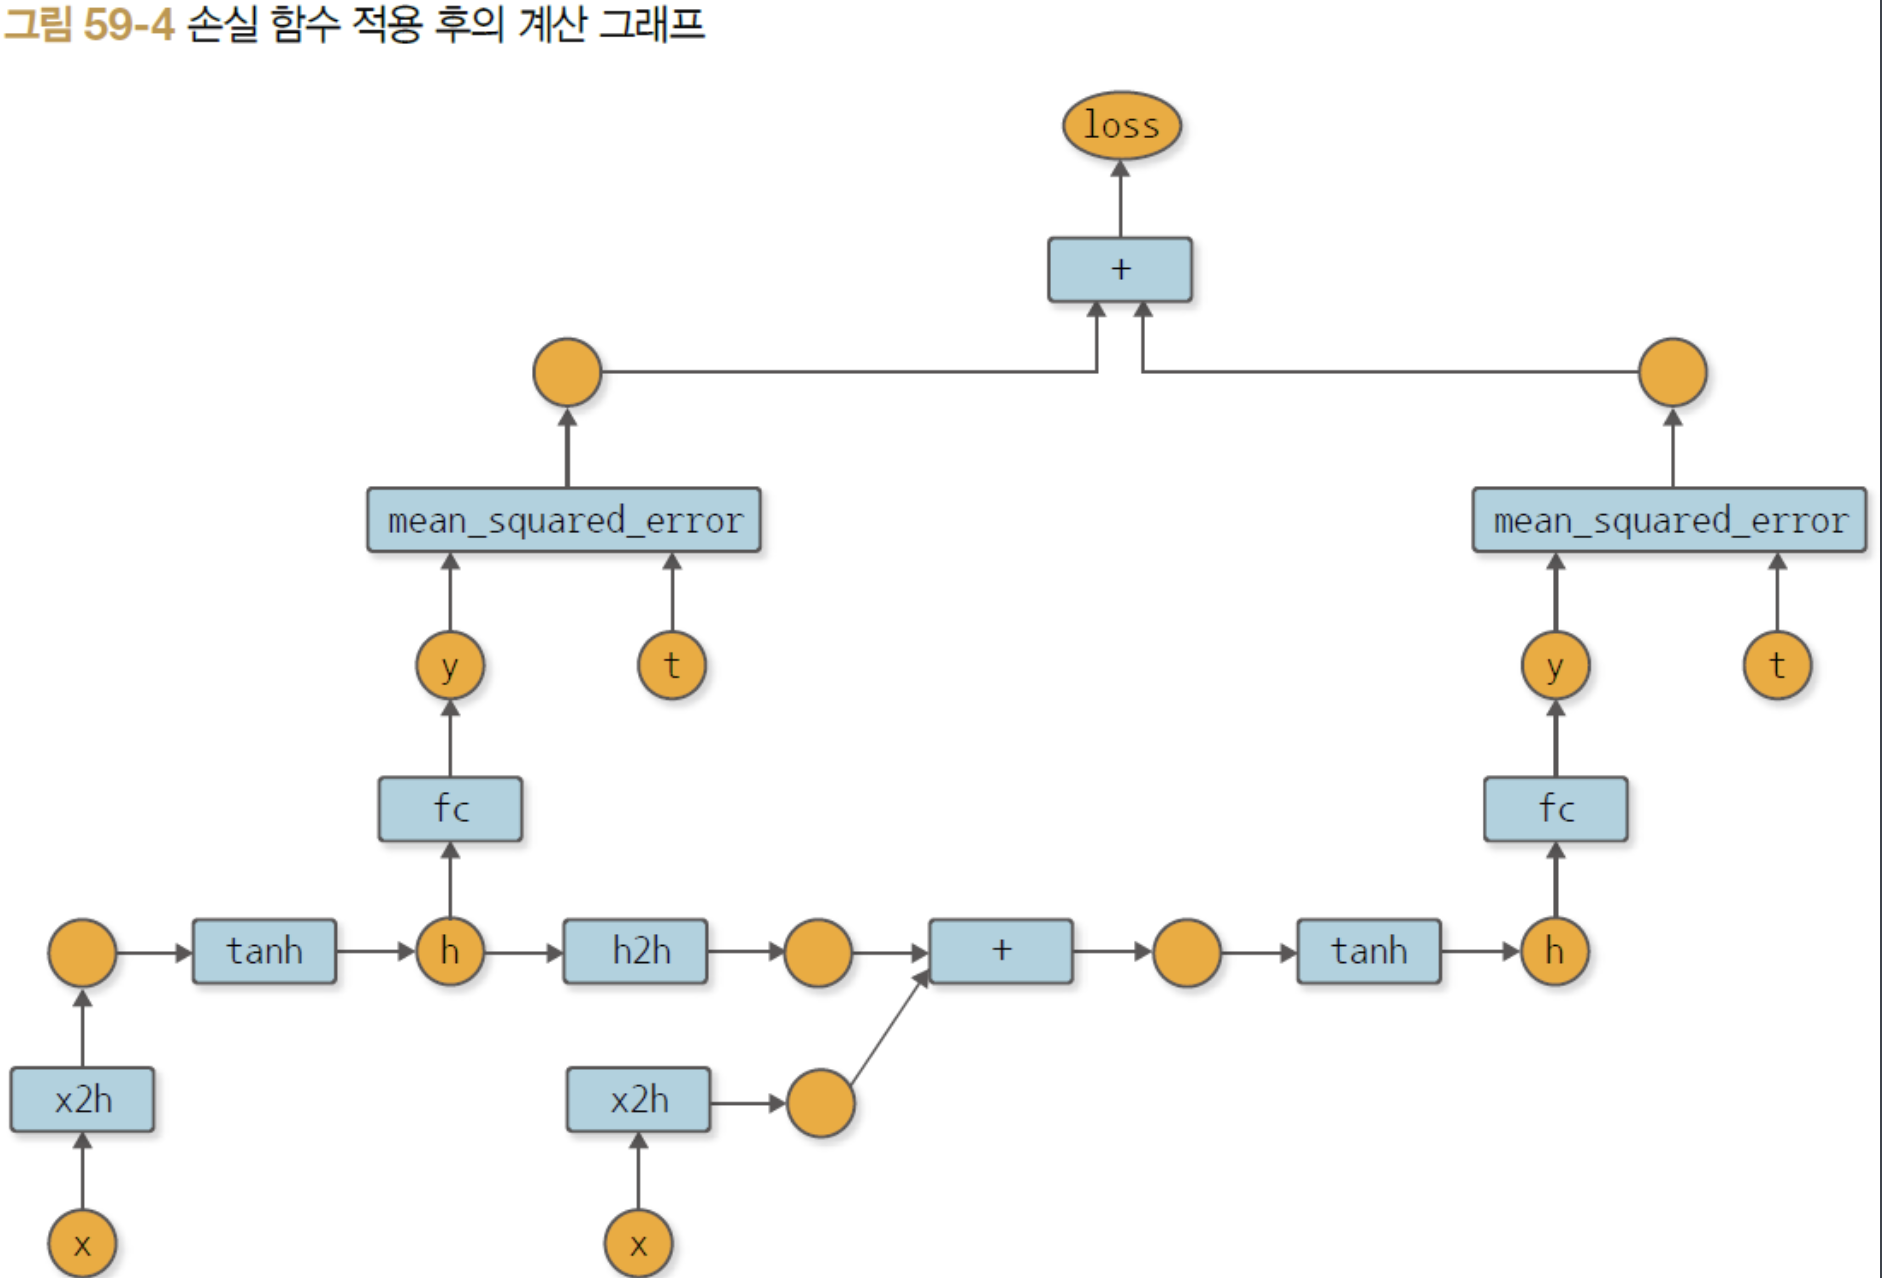

* 그림 59-4와 같은 계산 그래프가 만들어진 후로는 loss.backward()을 통해 각 매개변수의 기울기를 구할 수 있다.
* 이처럼 일련의 입력 데이터로 구성된 계산 그래프에서의 역전파를 '시간을 거슬러 역전파한다'는 의미를 담아 BPTT라고 한다.

* RNN은 입력 데이터가 '나열되는' 패턴을 학습할 수 있다.
* 이때 데이터의 나열 '순서'는 시계열 데이터의 '시간'에 해당한다.
* Backpropagation Through Time이라는 이름에 시간이 포함되는 이유이다.

* 그림 59-3는 데이터를 단 두 개만 입력했을 때의 계산 그래프이다.
* 물론 입력 데이터는 10개든 100개든 원하는 만큼 제공할 수 있다.
* 몇 개가 입력되는 계산 그래프는 문제 없이 계속 길게 뻗어간다.
* 하지만 역전파를 잘하려면 계산 그래프를 적당한 길이에서 '끊어줘야'한다.
* Truncated BPTT이다. 앞의 예에서 입력데이터 2개째에서 절단했다.

* Truncated BPTT를 수행할 때는 RNN의 은닉 상태가 유지된다는 점에 주의해야한다.
* 가령 그림 59-4의 계산 그래프에서 역전파를 한 후 그다음 입력 데이터를 더 제공하는 경우를 생각해보자
* 그렇다면 아래 그림처럼 RNN의 은닉 상태는 이전의 은닉 상태에서 시작해야한다.
* 그림 59-5와 같이 최초의 은닉 상태는 이전의 마지막 은닉 상태에서 시작한다.
* 그리고 그 은닉 상태 변수에서 계산의 '연결'을 끊어야한다.
* 그러면 이전 학스베서 사용한 계산 그래프로까지 기울기가 흐르지 못하게 된다.

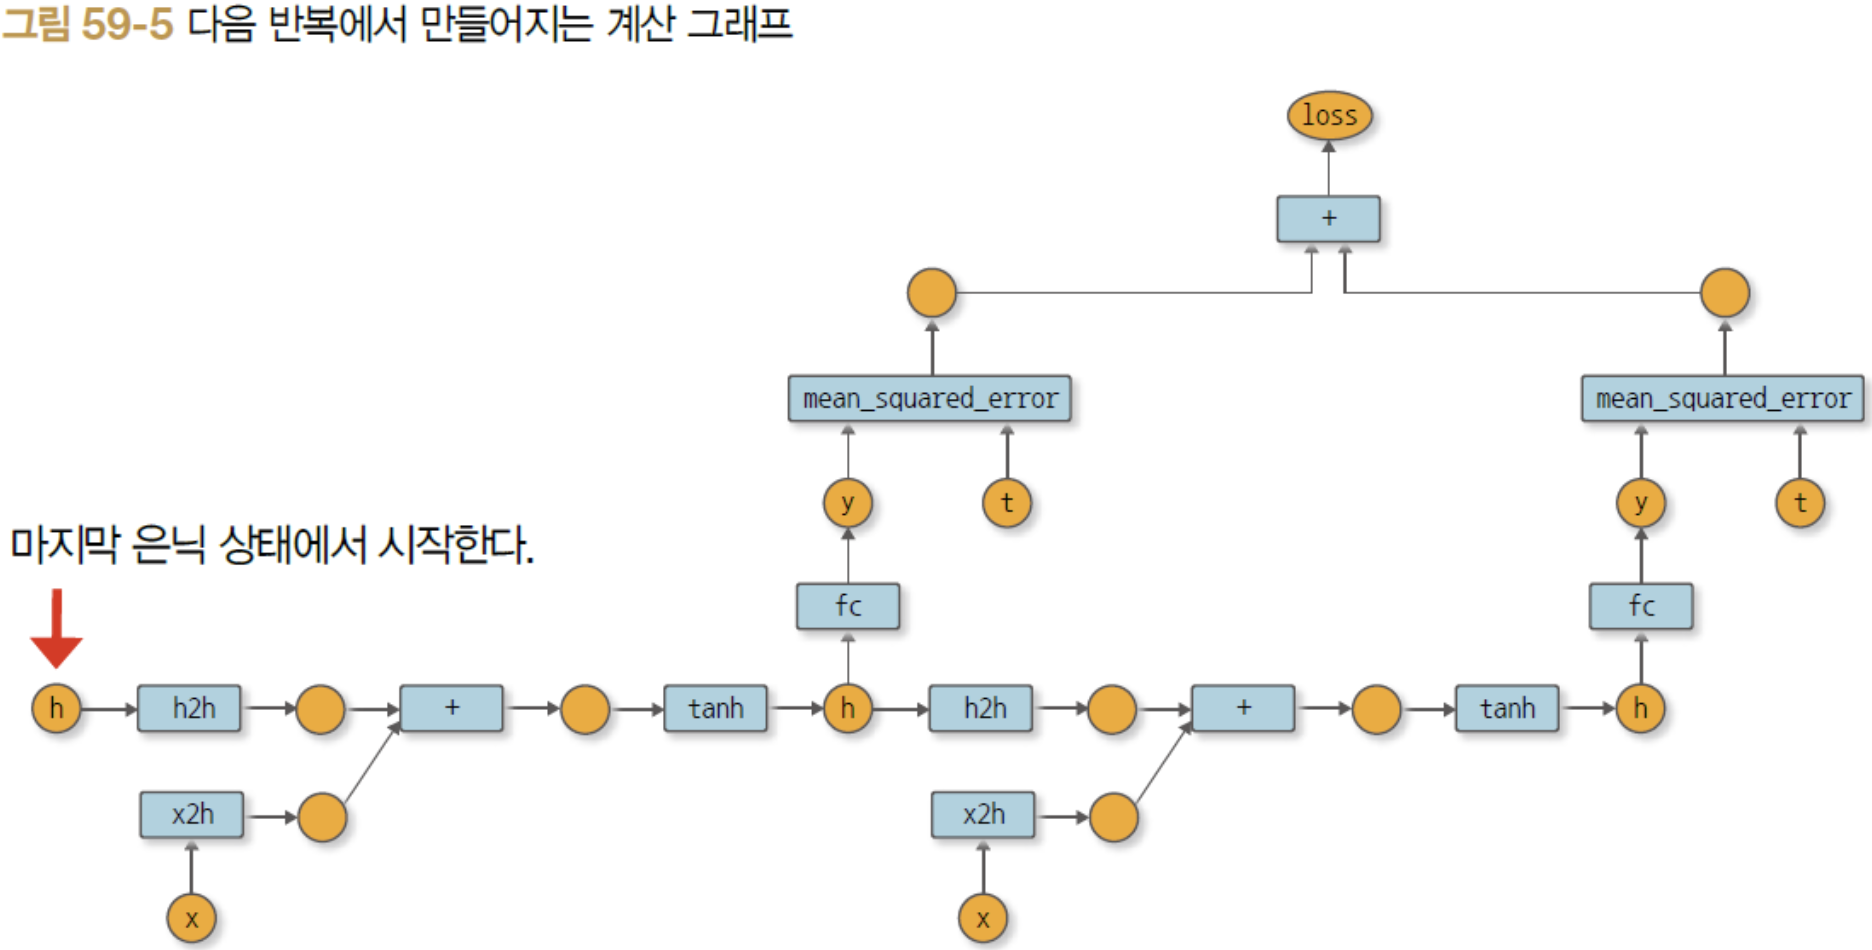

'연결'을 끊어주는 메서드
* 그래서 Variable 클래스에 '연결'을 끊어주는 메서드가 필요해진다.

In [ ]:
class Variable:
    ...
    def unchain(self):
        self.creator = None

* unchain 메서드는 창조자인 self.creator를 None으로 설정하는게 다이다.
* 단순히 부모 함수로의 연결을 끊는 것이다.
* 그런 다음 연결을 끊기 위한 편의 메서드를 하나 더 추가한다.
* 바로 unchain_backward 메서드이다.
* 이 메서드는 호출된 변수에서 시작하여 계산 그래프를 거술러 올라가며 마주치는 모든 변수의 unchain 메서드를 호출한다.

In [ ]:
class Variable:
  ...
    def unchain_backward(self):
        if self.creator is not None:
            funcs = [self.creator]
            while funcs:
                f = funcs.pop()
                for x in f.inputs:
                    if x.creator is not None:
                        funcs.append(x.creator)
                        x.unchain()

* 보면 변수와 함수를 거꾸로 거슬러 올라가면서 변수의 unchain 메서드를 호출한다.
* 거슬러 올라간다는 점에서 Variable 클래스의 backward 메서드와 같지만, 변수를 추적하는 순서(변수의 '세대')는 고려하지 않기 때문에 코드는 더 간결해진다.

사인파 예측

999
(array([0.01780957]), array([0.0111508]))
(array([0.0111508]), array([0.0413705]))
(array([0.0413705]), array([-0.00405372]))


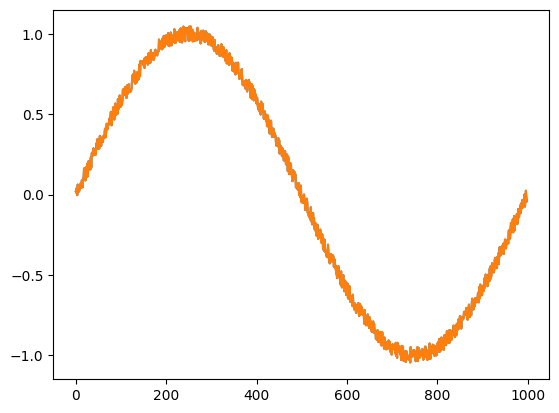

In [16]:
import numpy as np
import dezero
import matplotlib.pyplot as plt

train_set = dezero.datasets.SinCurve(train=True)
print(len(train_set))
print(train_set[0])
print(train_set[1])
print(train_set[2])

# 그래프 그리기
xs = [example[0] for example in train_set]
ts = [example[0] for example in train_set]
plt.plot(np.arange(len(xs)), xs, label='xs')
plt.plot(np.arange(len(ts)), ts, label='ts')
plt.show()



* 이 예에서는 train_set의 0,1,2번째 데이터를 출력했다.
* 각 데이터는 튜플이며, 첫 번째 원소가 입력 데이터, 두 번째 원소가 정답 데이터이다.
* 코드를 실행하면 다음 그래프가 모니터에 나타날 것이다.

* 위 그림같이 데이터는 노이즈가 낀 사인파이다.
* 근데 데이터를 분명 두 개 (xs,ts) 렌더링했는데, 곡선은 1개 뿐이다.
* 그 이유는 사실 ts가 xs보다 한 단계 앞선 데이터이기 떄문이다.
* 그래서 두 곡선이 거의 겹쳐 그려진 것이다.

* 사인파 데이터셋의 정답 데이터는 입력 데이터보다 한 단계 '미래'의 데이터이다.
* 앞의 코드로 말하면 xs[1:] == ts[:-1]이다.
* 이러한 데이터셋은 시계열 데이터를 예측하는 문제에 사용된다.

| epoch 1 | loss 0.353411
| epoch 2 | loss 0.059113
| epoch 3 | loss 0.023745
| epoch 4 | loss 0.005742
| epoch 5 | loss 0.003723
| epoch 6 | loss 0.002837
| epoch 7 | loss 0.002473
| epoch 8 | loss 0.002314
| epoch 9 | loss 0.002537
| epoch 10 | loss 0.002592
| epoch 11 | loss 0.003202
| epoch 12 | loss 0.003850
| epoch 13 | loss 0.004483
| epoch 14 | loss 0.004975
| epoch 15 | loss 0.005361
| epoch 16 | loss 0.005670
| epoch 17 | loss 0.005855
| epoch 18 | loss 0.005897
| epoch 19 | loss 0.005848
| epoch 20 | loss 0.005780
| epoch 21 | loss 0.005724
| epoch 22 | loss 0.005677
| epoch 23 | loss 0.005630
| epoch 24 | loss 0.005582
| epoch 25 | loss 0.005538
| epoch 26 | loss 0.005504
| epoch 27 | loss 0.005483
| epoch 28 | loss 0.005481
| epoch 29 | loss 0.005507
| epoch 30 | loss 0.005581
| epoch 31 | loss 0.005730
| epoch 32 | loss 0.006003
| epoch 33 | loss 0.006483
| epoch 34 | loss 0.007239
| epoch 35 | loss 0.008350
| epoch 36 | loss 0.009606
| epoch 37 | loss 0.012113
| epoch 38

/tmp/ipython-input-2615328696.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_list.append(float(y.data))


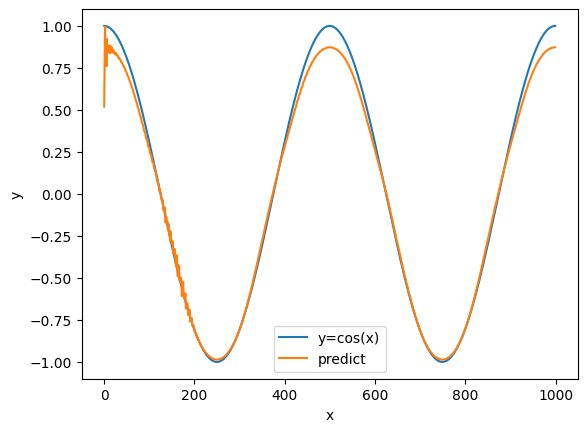

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import Model
import dezero.functions as F
import dezero.layers as L

# 하이퍼파라미터 설정
max_epoch = 100
hidden_size = 100
bptt_length = 30 # BPTT 길이

train_set = dezero.datasets.SinCurve(train=True)
seqlen = len(train_set)


class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def __call__(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y


model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

# 학습 시작
for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in train_set:
        x = x.reshape(1, 1) # 1 형상을 (1, 1)로 변환
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        # 2 Truncated BPTT의 타이밍 조정
        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update() # 3 연결 끊기

    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

# Plot
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

* 우선 1에서 x의 형상을 (1,1)로 변환한다.
* DeZero 신경망에서는 입력 데이터를 2차원 텐서 혹은 4차원 텐서로 제공해야한다.
* 따라서 입력 데이터가 하나뿐이라면 2차원 텐서인 (1,1)로 변환해야한다.

* 다음으로 2에서 backward 메서드를 언제 호출할지 결정한다.
* 데이터를 30번 흘려보냈을때 혹은 데이터셋의 마지막(끝에) 도달했을 때로 정했다.
* 마지막으로 3에서는 unchain_backward 메서드를 호출하여 RNN의 은닉 상태의 '연결'을 끊는다.

* 그러나 현재 구현에서는 데이터를 하나씩 처리하기 떄문에 시간이 오래 걸린다.
* 배치 크기를 늘리면 1에포크의 처리 시간이 단축된다.